# Evolution of commitment and level of participation in public goods games

### Import of library needed

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

/home/plouis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Definition of the PGG class

In [3]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                  group_size: int,   # number of participants in the PGG
                  c: float,          # cost of cooperation
                  r: float,          # enhancing factor (multiplier)
                  eps: float,        # cost for propose a commitment
                  delta : float,     # cost to don't respect the commitment
                  ):
          
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4, 5, 6, 7, 8

        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[COMP1] + group_composition[COMP2] + group_composition[COMP3] + group_composition[COMP4] + group_composition[COMP5]  # number of commitment
        
        if(nb_commitment==0):  # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else: #If one propose, we have can have a FREE player
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]  # number of contributors
        
        nb_fake = group_composition[FAKER]  # number of fake
        nb_accept = group_composition[FAKER] + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)

        # Find F
        F = int(0)
        comp = int(0)
        for i in group_composition[:5]:
          comp+=1
          if(i>0):
            F=comp

        if F <= nb_accept or nb_commitment==0: #le nombre de gens qui acceptent le contrat doit être plus grand que F
        #ou le nombre de COMP est égal à 0 et on joue juste un PGG classique
          for index, strategy_count in enumerate(group_composition):
              if strategy_count > 0:  # (else: it's not in the group, its payoff is 0)
                game_payoffs[index] += individual_reward
                if "COMP" in self.strategies[index]:
                  game_payoffs[index] -=  (self.c + (self.eps/nb_commitment)- ((nb_fake*self.delta)/nb_commitment))
                elif self.strategies[index] == "C":
                  game_payoffs[index] -=  self.c
                if(nb_commitment > 0):
                  if self.strategies[index] == "FAKE":
                    game_payoffs[index] -= self.delta
                  elif self.strategies[index] == "FREE":
                      game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


## 4.1 Constraints on the evolutionary viability of COMPF

In [4]:
# Parameters of the game:
strategy_labels = ["F=1","F=2","F=3","F=4","F=5" ,"C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 1.0
beta = 0.25
r = 4.
eps = 0.25
delta = 2.


In [5]:
game = PGGWithCommitment(group_size, c, r, eps, delta)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

### Figure 3.a

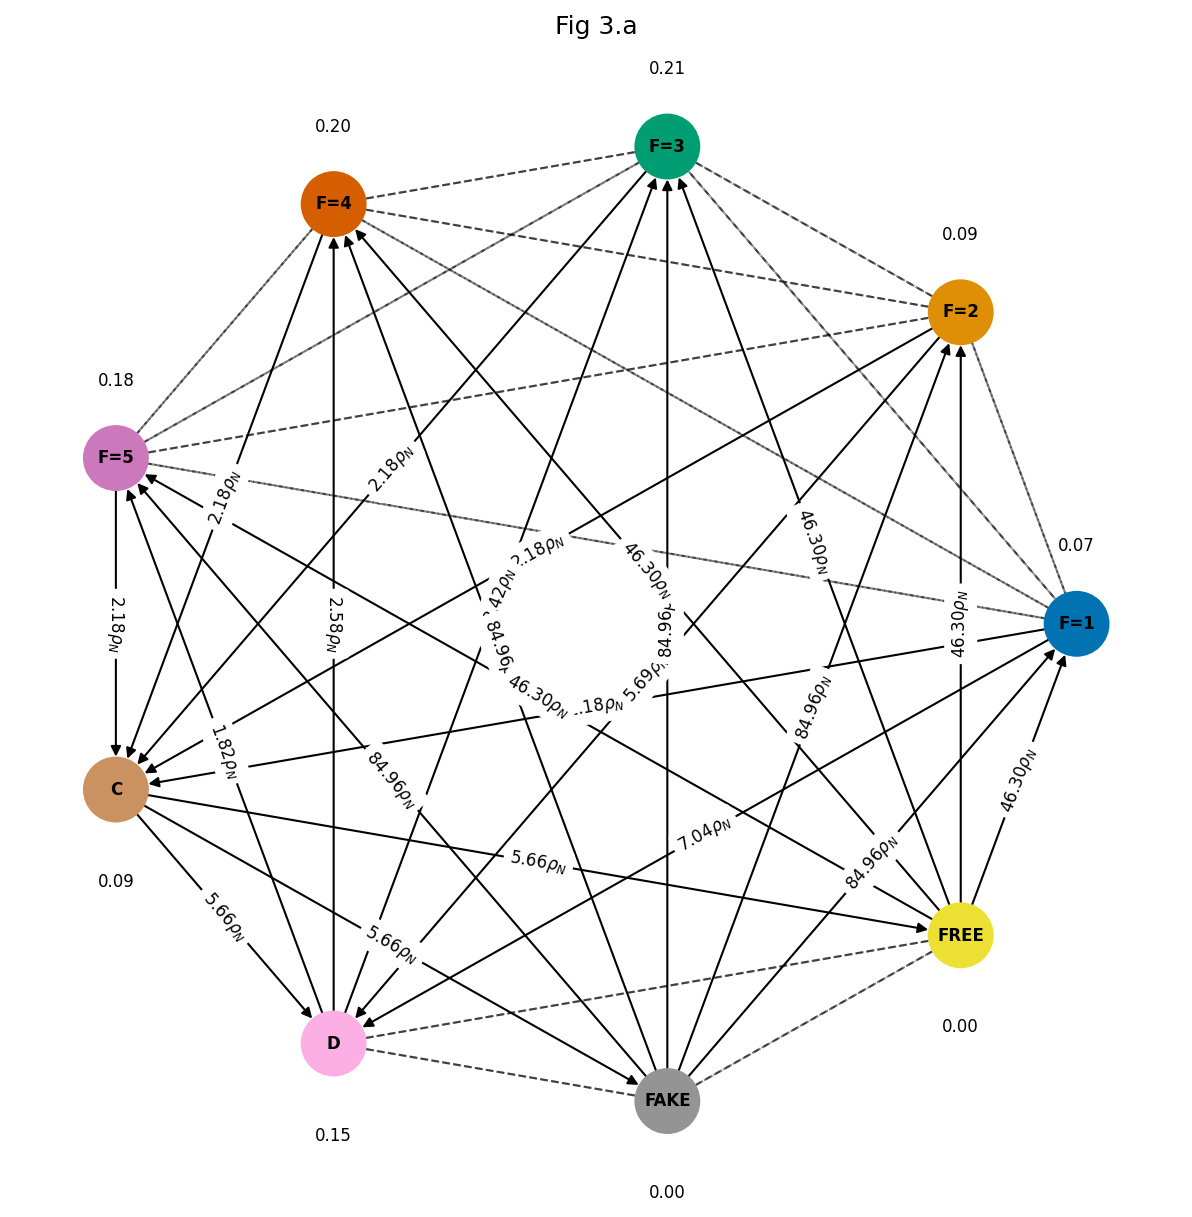

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.title("Fig 3.a")
plt.show() # display

### Figure 3.b and 3.c

In [7]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

avoid_frequency_b = np.zeros((nb_points, nb_points), dtype = float)
avoid_frequency_c = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        avoid_frequency_b[i,j] = sum(stationary_distribution[0:6])
        avoid_frequency_c[i,j] = sum(stationary_distribution[0:5])

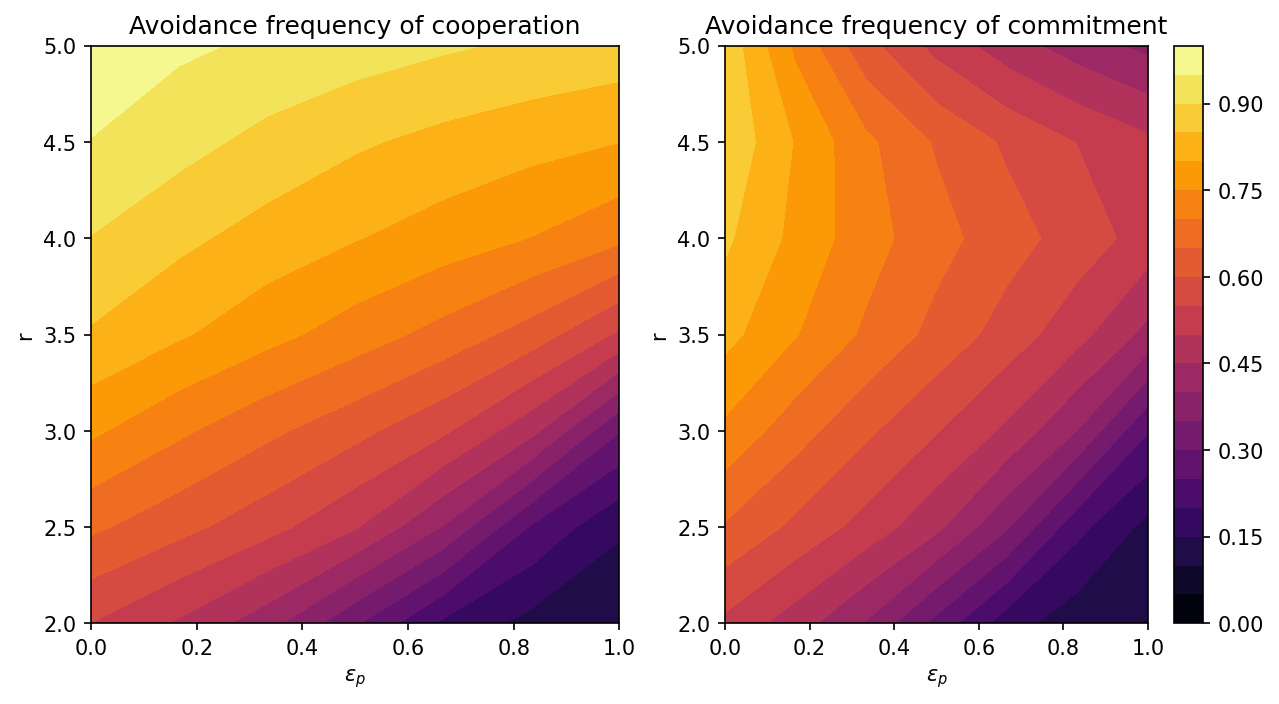

In [8]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

plt.figure(figsize=(10, 5), dpi=150)
plt.subplot(1, 2, 1)
plt.contourf(eps_values, r_values, avoid_frequency_b.T, levels=levels, cmap='inferno', vmin = 0., vmax = 1.)
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title("Avoidance frequency of cooperation")

plt.subplot(1, 2, 2)
plt.contourf(eps_values, r_values, avoid_frequency_c.T, levels=levels, cmap='inferno', vmin = 0., vmax = 1.)
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title("Avoidance frequency of commitment")
plt.colorbar(orientation='vertical')
plt.show()

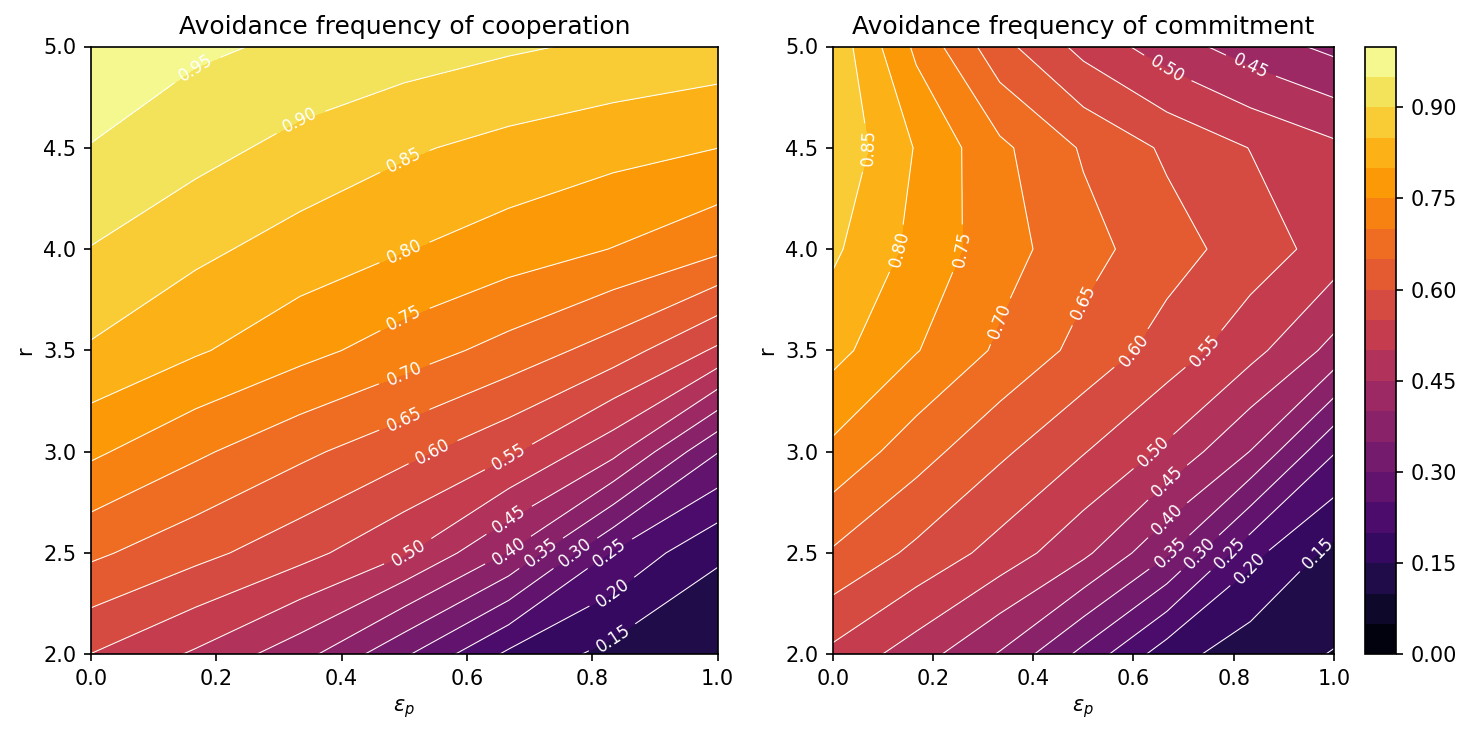

In [9]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 1., 21)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(eps_values, r_values, avoid_frequency_b.T, levels=levels, cmap='inferno', vmin=0., vmax=1.)
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_b.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title("Avoidance frequency of cooperation")

# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(eps_values, r_values, avoid_frequency_c.T, levels=levels, cmap='inferno', vmin=0., vmax=1.)
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_c.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, fontsize=8, fmt="%.2f") 
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title("Avoidance frequency of commitment")


plt.tight_layout()
plt.show()


## 4.2 Emergence of cooperation and sufficient participation levels

## 4.3 Lenience in long-term commitments

In [10]:
class PGGWithCommitment_R(AbstractNPlayerGame):
    def __init__(self, 
                  group_size: int,   # number of participants in the PGG
                  c: float,          # cost of cooperation
                  r: float,          # enhancing factor (multiplier)
                  eps: float,        # cost for propose a commitment
                  delta : float,     # cost to don't respect the commitment
                  R : int, 
                  ):
          
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.R = R # Round number
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4, 5, 6, 7, 8

        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[COMP1] + group_composition[COMP2] + group_composition[COMP3] + group_composition[COMP4] + group_composition[COMP5]  # number of commitment
        
        if(nb_commitment==0):  # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else: #If one propose, we have can have a FREE player
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]  # number of contributors
        
        nb_fake = group_composition[FAKER]  # number of fake
        nb_accept = group_composition[FAKER] + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)

        # Find F
        F = int(0)
        comp = int(0)
        for i in group_composition[:5]:
          comp+=1
          if(i>0):
            F=comp

        for round in range(self.R):
          if F <= nb_accept or nb_commitment==0: #le nombre de gens qui acceptent le contrat doit être plus grand que F
          #ou le nombre de COMP est égal à 0 et on joue juste un PGG classique
            for index, strategy_count in enumerate(group_composition):
                if strategy_count > 0:  # (else: it's not in the group, its payoff is 0)
                  game_payoffs[index] += individual_reward
                  if "COMP" in self.strategies[index]:
                    game_payoffs[index] -=  (self.c + (self.eps/nb_commitment)- ((nb_fake*self.delta)/nb_commitment))
                  elif self.strategies[index] == "C":
                    game_payoffs[index] -=  self.c
                  if(nb_commitment > 0):
                    if self.strategies[index] == "FAKE":
                      game_payoffs[index] -= self.delta
                    elif self.strategies[index] == "FREE":
                        game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


In [11]:
# Parameters of the game:
strategy_labels = ["F=1","F=2","F=3","F=4","F=5" ,"C", "D", "FAKE", "FREE"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 1.0
beta = 0.25
delta = 6.

In [12]:
nb_points = 5
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

average_F = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        average_F[i, j] = sum(stationary_distribution[0:5] * np.arange(1, 6)) / sum(stationary_distribution[0:5])

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(average_F)
print("Min : ", np.min(average_F))
print("Max : ", np.max(average_F))

Matrice des moyennes F :
[[3.99302854 3.79897177 3.52173426 3.27294544 3.08668255]
 [3.94419106 3.82891973 3.56481268 3.36625263 3.14085538]
 [3.8877211  3.80737078 3.60724758 3.4291359  3.20938743]
 [3.92460506 3.74410805 3.63359863 3.46366952 3.29593777]
 [3.94355811 3.7808127  3.5996287  3.47805807 3.36343972]]
Min :  3.0866825539607854
Max :  3.993028542783246


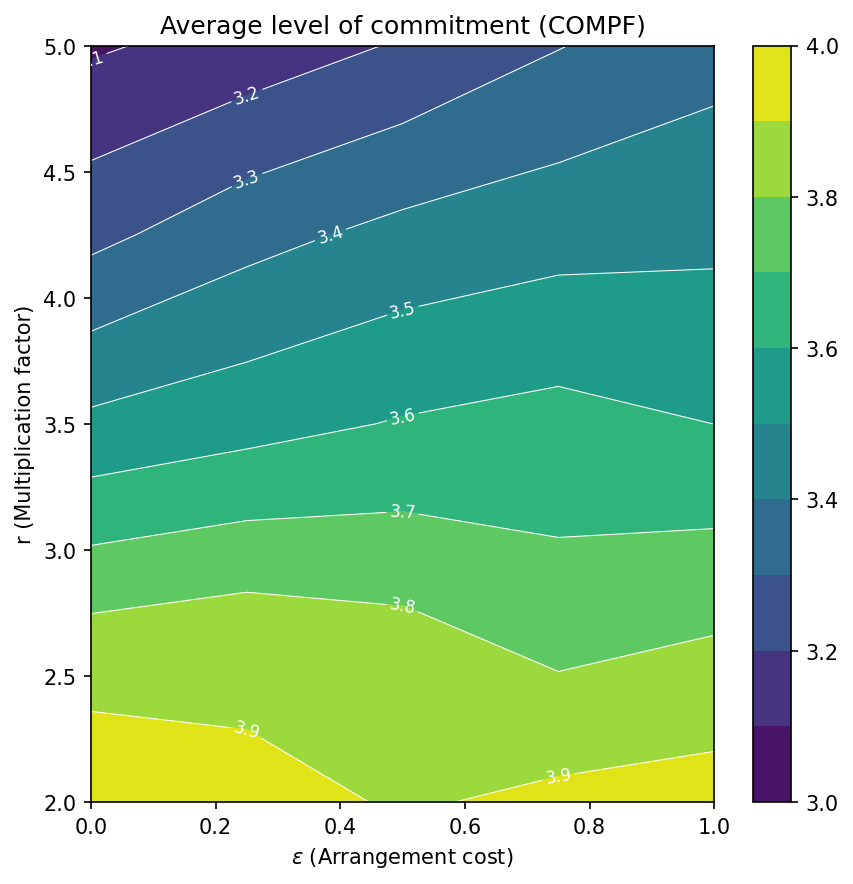

In [13]:
# Plot the average level of commitment
plt.figure(figsize=(6, 6), dpi=150)

levels = np.linspace(3.0, 4.0, 11)
contour = plt.contourf(eps_values, r_values, average_F.T, levels=levels, cmap='viridis')
contour_lines = plt.contour(eps_values, r_values, average_F.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f")
plt.xlabel(r'$\epsilon$ (Arrangement cost)')
plt.ylabel('r (Multiplication factor)')
plt.title('Average level of commitment (COMPF)')
plt.colorbar(contour)

plt.tight_layout()
plt.show()

In [14]:
nb_points = 5
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

optimal_F = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGWithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F)
print("Min : ", np.min(optimal_F))
print("Max : ", np.max(optimal_F))

Matrice des moyennes F :
[[5. 4. 4. 3. 2.]
 [5. 4. 4. 3. 3.]
 [5. 4. 4. 3. 3.]
 [5. 4. 4. 3. 3.]
 [5. 4. 4. 3. 3.]]
Min :  2.0
Max :  5.0


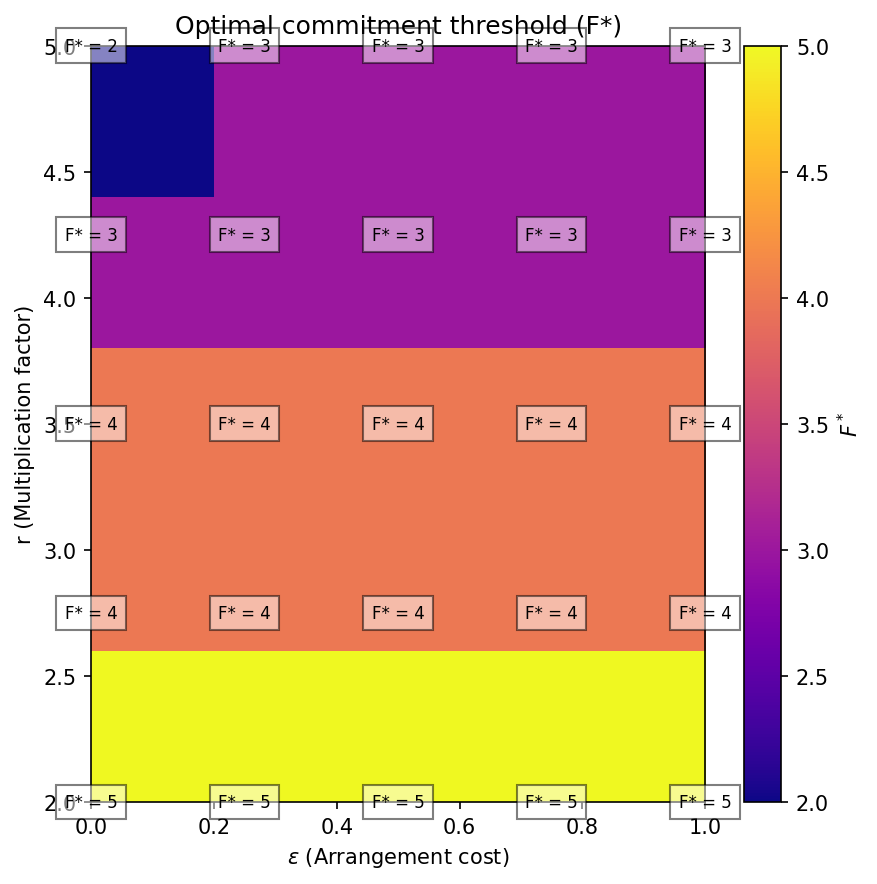

In [15]:
# Tracer la figure
plt.figure(figsize=(6, 6), dpi=150)

# Graphique discrétisé (zones de couleurs pour F*)
contour = plt.imshow(optimal_F.T, origin='lower', extent=[0, 1, 2, 5], aspect='auto', cmap='plasma')
plt.colorbar(label=r"$F^*$")

# Annotations pour chaque zone
for i in range(nb_points):
    for j in range(nb_points):
        plt.text(eps_values[i], r_values[j], f"F* = {int(optimal_F[i, j])}",
                 color='black', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Axes et labels
plt.xlabel(r'$\epsilon$ (Arrangement cost)')
plt.ylabel('r (Multiplication factor)')
plt.title("Optimal commitment threshold (F*)")
plt.tight_layout()
plt.show()

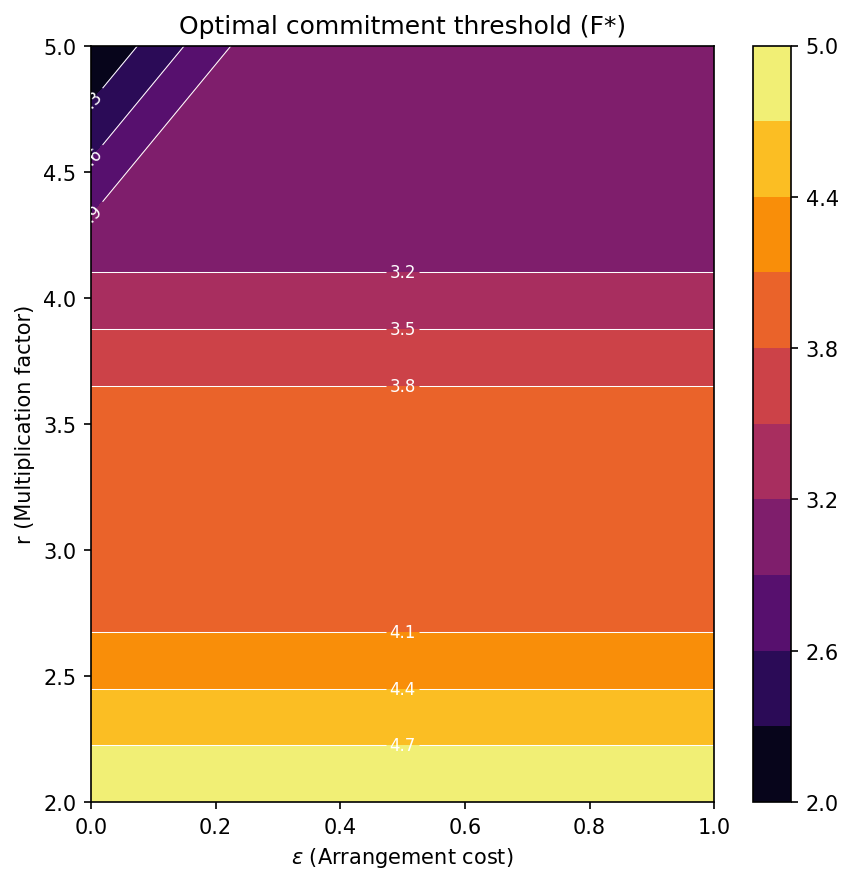

In [16]:
# Tracer la figure
plt.figure(figsize=(6, 6), dpi=150)

levels = np.linspace(2.0, 5.0, 11)
contour = plt.contourf(eps_values, r_values, optimal_F.T, levels=levels, cmap='inferno')
contour_lines = plt.contour(eps_values, r_values, optimal_F.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f")
plt.xlabel(r'$\epsilon$ (Arrangement cost)')
plt.ylabel('r (Multiplication factor)')
plt.title('Optimal commitment threshold (F*)')
plt.colorbar(contour)

plt.tight_layout()
plt.show()

In [17]:
r_c = 2.5
nb_points = 5
eps_values = np.linspace(0., 1., nb_points)
delta_values = np.linspace(2., 5., nb_points)

optimal_F_r25 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        game = PGGWithCommitment(group_size, c, r_c, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F_r25[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F_r25)
print("Min : ", np.min(optimal_F_r25))
print("Max : ", np.max(optimal_F_r25))

Matrice des moyennes F :
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]]
Min :  4.0
Max :  5.0


In [ ]:
r_d = 4.0
nb_points = 5
eps_values = np.linspace(0., 1., nb_points)
delta_values = np.linspace(2., 5., nb_points)

optimal_F_r40 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        game = PGGWithCommitment(group_size, c, r_d, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        optimal_F_r40[i, j] = np.argmax(stationary_distribution[0:5]) + 1

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(optimal_F_r40)
print("Min : ", np.min(optimal_F_r40))
print("Max : ", np.max(optimal_F_r40))

Matrice des moyennes F :
[[3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]
Min :  3.0
Max :  4.0


/tmp/ipykernel_1164/1744472525.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


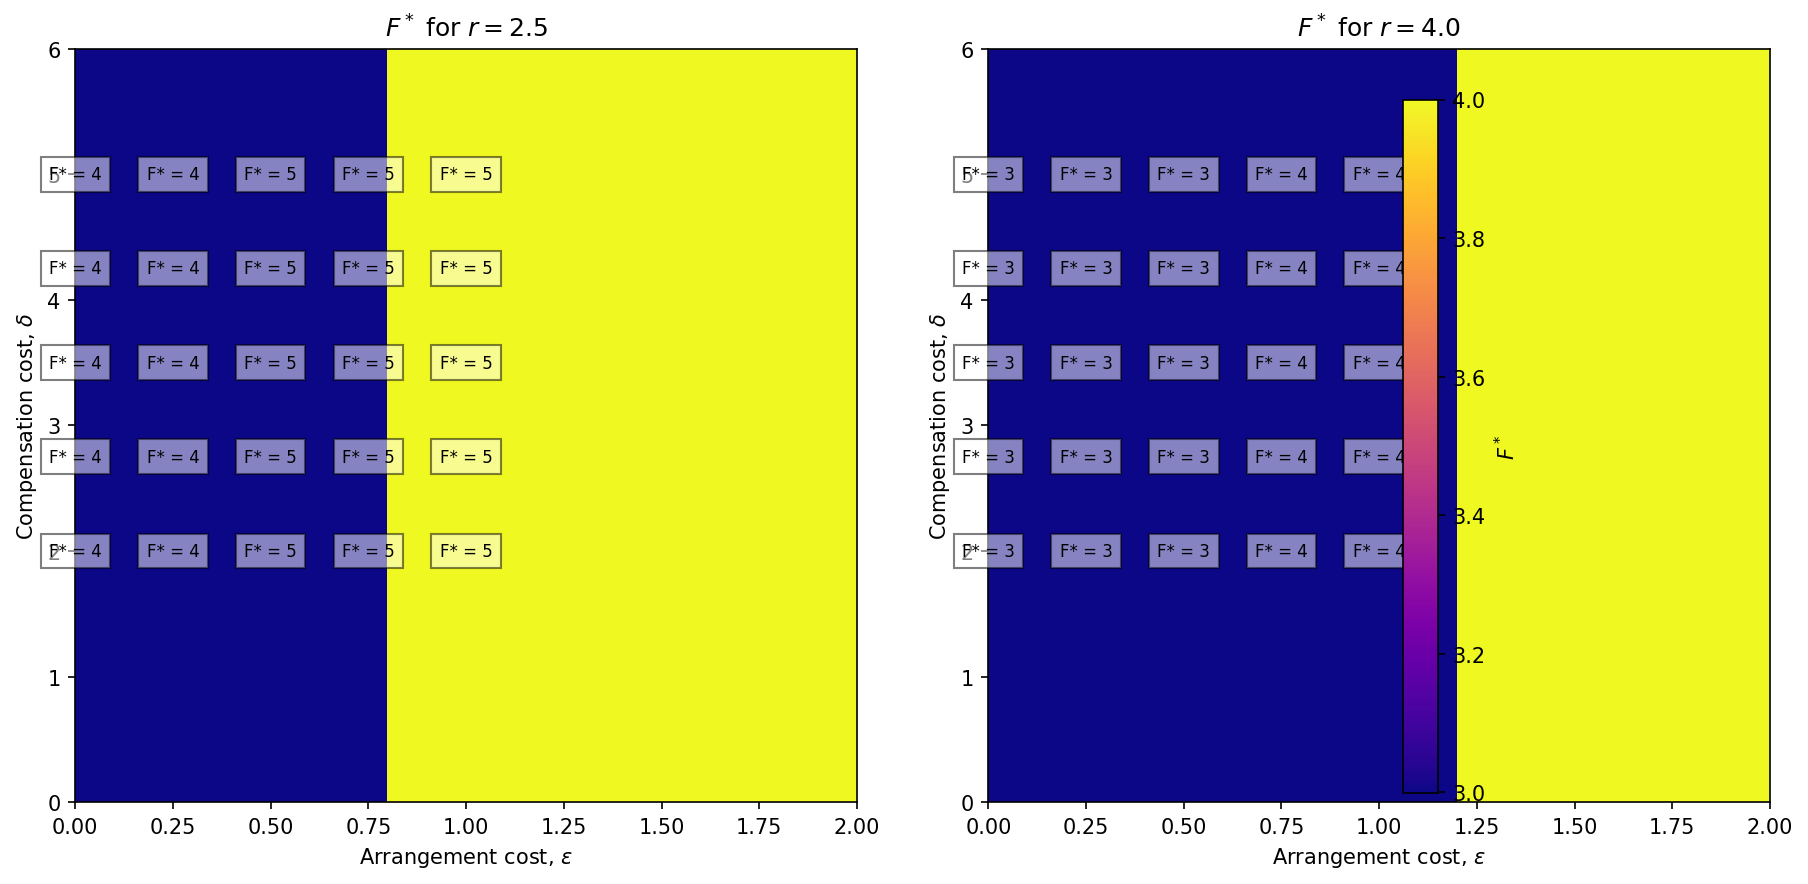

In [19]:
# Tracer les figures c et d
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Figure c : r = 2.5
ax = axes[0]
contour = ax.imshow(optimal_F_r25.T, origin='lower', extent=[0, 2, 0, 6], aspect='auto', cmap='plasma')
ax.set_xlabel(r'Arrangement cost, $\epsilon$')
ax.set_ylabel(r'Compensation cost, $\delta$')
ax.set_title(r'$F^*$ for $r = 2.5$')

# Annotations pour chaque zone
for i in range(nb_points):
    for j in range(nb_points):
        ax.text(eps_values[i], delta_values[j], f"F* = {int(optimal_F_r25[i, j])}",
                color='black', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Figure d : r = 4.0
ax = axes[1]
contour = ax.imshow(optimal_F_r40.T, origin='lower', extent=[0, 2, 0, 6], aspect='auto', cmap='plasma')
ax.set_xlabel(r'Arrangement cost, $\epsilon$')
ax.set_ylabel(r'Compensation cost, $\delta$')
ax.set_title(r'$F^*$ for $r = 4.0$')
# Annotations pour chaque zone
for i in range(nb_points):
    for j in range(nb_points):
        ax.text(eps_values[i], delta_values[j], f"F* = {int(optimal_F_r40[i, j])}",
                color='black', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Ajouter une barre de couleurs
fig.colorbar(contour, ax=axes, orientation='vertical', label=r"$F^*$")
plt.tight_layout()
plt.show()

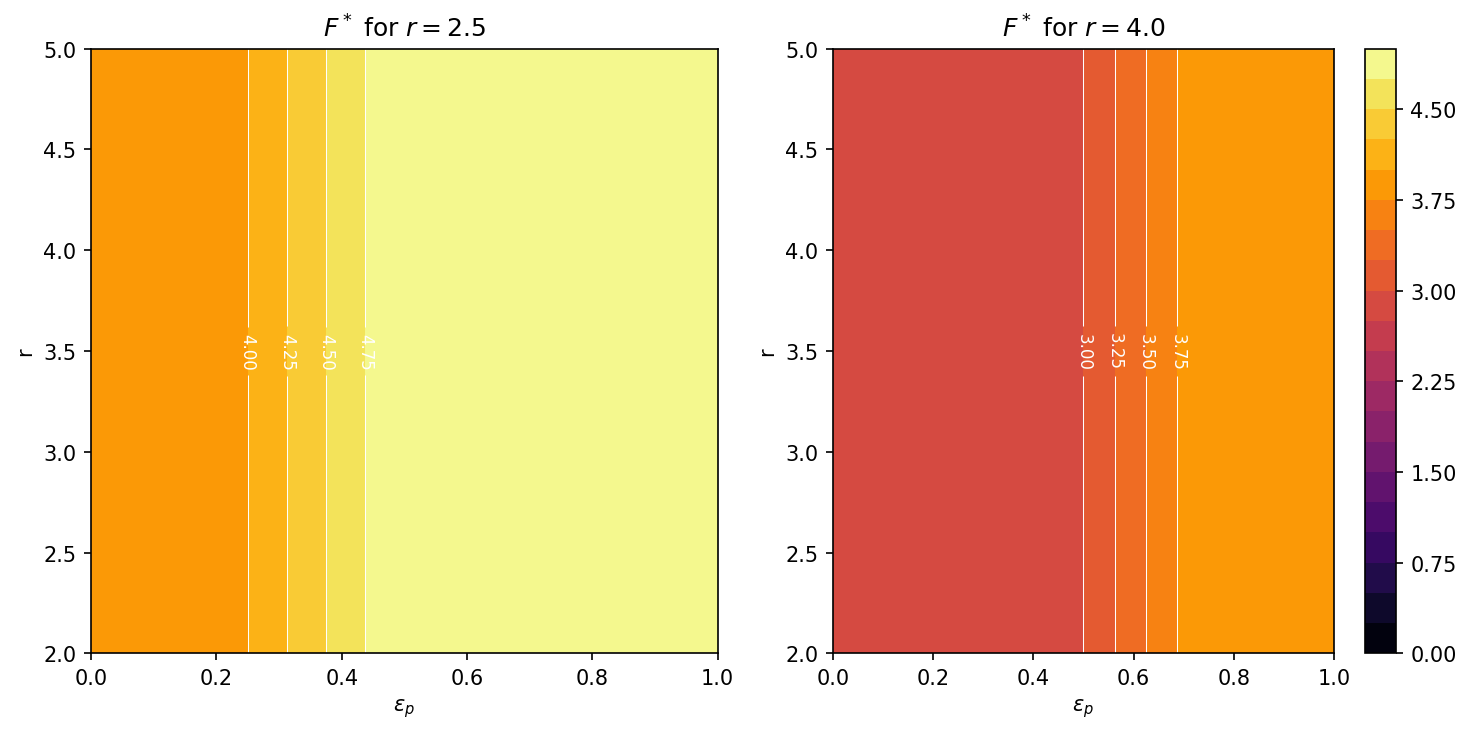

In [20]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 5., 21)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(eps_values, r_values, optimal_F_r25.T, levels=levels, cmap='inferno')
contour_lines = plt.contour(eps_values, r_values, optimal_F_r25.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title(r'$F^*$ for $r = 2.5$')

# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(eps_values, r_values, optimal_F_r40.T, levels=levels, cmap='inferno')
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, r_values, optimal_F_r40.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, fontsize=8, fmt="%.2f") 
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title(r'$F^*$ for $r = 4.0$')


plt.tight_layout()
plt.show()

### Plot figure 6.a and 6.b

Les gains entre deux types différents de stratégies COMP_F,F′ sont les mêmes que les gains entre deux types différents de stratégies COMP_F dans le jeu en une seule manche (i.e. 
𝑟
𝑐
−
𝑐
−
𝑁
rc−c−N), car ils s'engagent tous et coopèrent à toutes les manches.

### Last class of Louis with 29 strats

PGG class defintion 

In [4]:
class PGGWithLongCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 R: int             # Number of rounds
                 ):
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 29, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 29
        self.group_size_ = group_size
        self.strategies = [
            "COMP1_1", "COMP1_2", "COMP1_3", "COMP1_4", "COMP1_5",
            "COMP1_2", "COMP2_2", "COMP3_2", "COMP4_2", "COMP5_2",
            "COMP1_3", "COMP2_3", "COMP3_3", "COMP4_3", "COMP5_3",
            "COMP1_4", "COMP2_4", "COMP3_4", "COMP4_4", "COMP5_4",
            "COMP1_5", "COMP2_5", "COMP3_5", "COMP4_5", "COMP5_5",
            "C", "D", "FAKE", "FREE"
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.R = R  # Number of rounds
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1_1, COMP1_2, COMP1_3, COMP1_4, COMP1_5 = 0, 1, 2, 3, 4
        COMP1_2, COMP2_2, COMP3_2, COMP4_2, COMP5_2 = 5, 6, 7, 8, 9
        COMP1_3, COMP2_3, COMP3_3, COMP4_3, COMP5_3 = 10, 11, 12, 13, 14
        COMP1_4, COMP2_4, COMP3_4, COMP4_4, COMP5_4 = 15, 16, 17, 18, 19
        COMP1_5, COMP2_5, COMP3_5, COMP4_5, COMP5_5 = 20, 21, 22, 23, 24
        COOPERATOR, DEFECTOR, FAKER, FREE = 25, 26, 27, 28

        # Calculate the number of each type of player in the group
        nb_commitment = sum(group_composition[:25])  # Number of commitment strategies

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]

        nb_fake = group_composition[FAKER]  # Number of fake players
        nb_accept = nb_fake + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        # Determine F (minimum commitment threshold) and F_prime
        F = next((i + 1 for i, count in enumerate(group_composition[:25]) if count > 0), 0)
        F_prime = next((int(self.strategies[i].split('_')[-1]) for i in range(25) if group_composition[i] > 0 and '_' in self.strategies[i]), 0)
    
        for round in range(self.R):
            if (F <= nb_accept or nb_commitment == 0) and nb_contributors >= F_prime:  # Check thresholds F and F_prime
                for index, strategy_count in enumerate(group_composition):
                    if strategy_count > 0:  # Players in the group
                        game_payoffs[index] += individual_reward
                        if index < 25:  # COMP strategies
                            game_payoffs[index] -= (self.c + (self.eps / nb_commitment) - ((nb_fake * self.delta) / nb_commitment))
                        elif index == COOPERATOR:
                            game_payoffs[index] -= self.c
                        if nb_commitment > 0:
                            if index == FAKER:
                                game_payoffs[index] -= self.delta
                            elif index == FREE:
                                game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""

        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


Test on game PGG

In [ ]:
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2, 5, 10, 20, 50, 100])
r_values = np.linspace(2.0, 5.0, 6)  # Example range for r
r= 2.0
R= 1
game = PGGWithLongCommitment(group_size, c, r, eps, delta, R)

# Calculate the stationary distribution
evolver = PairwiseComparison(Z, game)
transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

Try the whole loop to display the figure

In [ ]:
# Parameters
group_size = 5
c = 1.35
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2, 5, 10, 20, 50, 100])
r_values = np.linspace(2.0, 5.0, 6)  # Example range for r

# Storage for results
average_F_prime = np.zeros((len(r_values), len(R_values)))
optimal_F_prime = np.zeros((len(r_values), len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        # Initialize the game
        game = PGGWithLongCommitment(group_size, c, r, eps, delta, R)

        # Calculate the stationary distribution
        evolver = PairwiseComparison(Z, game)
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

        # Calculate average and optimal F'
        F_prime_levels = np.arange(1, 6)  # Possible F' levels
        strategy_indices = [game.strategies.index(f"COMP{i}{j}") for i in range(1, 6) for j in range(1, 6)]
        
        # Average F' based on stationary distribution
        average_F_prime[j, i] = sum(F_prime * sum(stationary_distribution[idx] for idx in strategy_indices if f"COMP{i}_{F_prime}" in game.strategies)
                                    for F_prime in F_prime_levels)
        
        # Optimal F' based on highest frequency
        strategy_frequencies = [sum(stationary_distribution[idx] for idx in strategy_indices if f"COMP{i}_{F_prime}" in game.strategies) for F_prime in F_prime_levels]
        optimal_F_prime[j, i] = F_prime_levels[np.argmax(strategy_frequencies)]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Average F' contour plot
ax = axs[0]
levels = np.linspace(np.min(average_F_prime), np.max(average_F_prime), 50)
contour = ax.contourf(R_values, r_values, average_F_prime, levels=levels, cmap='inferno')
contour_lines = ax.contour(R_values, r_values, average_F_prime, levels=levels, colors='white', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")
ax.set_title("Average F' Level")
ax.set_xlabel("R (Number of Rounds)")
ax.set_ylabel("r (Enhancing Factor)")
fig.colorbar(contour, ax=ax)

# Optimal F' contour plot
ax = axs[1]
levels = np.arange(1, 6, 1)
contour = ax.contourf(R_values, r_values, optimal_F_prime, levels=levels, cmap='viridis')
contour_lines = ax.contour(R_values, r_values, optimal_F_prime, levels=levels, colors='white', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%d")
ax.set_title("Optimal F' Level")
ax.set_xlabel("R (Number of Rounds)")
ax.set_ylabel("r (Enhancing Factor)")
fig.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()


### Code de theo a corrigé pour la figure 6

Utilse une autre class qui ne contient PAS les 29 strats mais qui tente de faire varier les 9 strats en faisant varier F'

In [10]:
eps = 0.25
delta = 20.
beta = 0.25

nb_points = 6
R_values = np.array([2, 5, 10, 20, 50, 100])
r_values = np.linspace(2., 5., nb_points)

average_F_prime = np.zeros((nb_points, len(R_values)))
optimal_F_prime = np.zeros((nb_points, len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        game = PGGWithLongCommitment(group_size, c, r, eps, delta, R,i)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        

        # Vérification de la taille
        #print(f"{i},{j} - Stationary Distribution:", stationary_distribution)

        # Sélection des 5 premières stratégies COMPF
        freq_COMPF = stationary_distribution[:5]
        #print(f"{i},{j} - Frequencies COMPF:", freq_COMPF)

        # Vérification de la somme
        freq_sum = sum(freq_COMPF)
        # print(f"{i},{j} - Somme des fréquences:", freq_sum)
        # Limiter aux 5 premières stratégies COMPF (indices 0 à 4)
                # Calcul des moyennes uniquement si freq_sum > 0
        if freq_sum > 0:  # Tolérance minimale
            F_values = np.arange(1, 6)  # F=1 à F=5
            average_F_prime[i, j] = sum(freq_COMPF * F_values) / freq_sum
            optimal_F_prime[i, j] = F_values[np.argmax(freq_COMPF)]
        else:
            average_F_prime[i, j] = 0
            optimal_F_prime[i, j] = 0

        average_F_prime[i, j] = sum(stationary_distribution[0:5] * np.arange(1, 6)) / sum(stationary_distribution[0:5])
        optimal_F_prime[i, j] = np.argmax(stationary_distribution[0:5]) + 1  

# Vérifier les valeurs calculées
print("Matrice des moyennes F :")
print(average_F_prime)
print("Min : ", np.min(average_F_prime))
print("Max : ", np.max(average_F_prime))

print("Matrice des moyennes F :")
print(optimal_F_prime)
print("Min : ", np.min(optimal_F_prime))
print("Max : ", np.max(optimal_F_prime))

Matrice des moyennes F :
[[3.         3.         3.         3.         3.         3.        ]
 [3.94419052 3.8633046  3.66892961 3.48836282 3.31535268 3.14085537]
 [4.19311517 4.05750146 3.83015315 3.58853429 3.40869538 3.13428832]
 [4.3340241  4.11981279 3.92326076 3.62573706 3.46728702 3.1325617 ]
 [4.42575897 4.14966562 3.9916781  3.64373448 3.50898199 3.13015638]
 [4.48481734 4.16565018 4.04330879 3.65311437 3.53951325 3.1267514 ]]
Min :  3.000000000000009
Max :  4.484817335817047
Matrice des moyennes F :
[[2. 2. 2. 2. 2. 2.]
 [5. 4. 4. 3. 3. 3.]
 [5. 4. 4. 3. 3. 2.]
 [5. 4. 4. 3. 3. 2.]
 [5. 4. 4. 3. 3. 2.]
 [5. 4. 4. 3. 3. 2.]]
Min :  2.0
Max :  5.0


Code pour plot la figure de theo 

In [1]:
# Tracer les figures 6a et 6b
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Figure 6a : Moyenne de F'
ax = axes[0]
levels = np.linspace(2, 5, 50)  # Plages des valeurs attendues
contour = ax.contourf(R_values, r_values, average_F_prime, levels=levels, cmap='inferno')
contour_lines = ax.contour(R_values, r_values, average_F_prime, levels=levels, colors='white', linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")
ax.set_xlabel('Periods, R')
ax.set_ylabel('Multiplication factor, r')
ax.set_title('Average F\'')
fig.colorbar(contour, ax=ax)

# Figure 6b : Optimal F'
ax = axes[1]
contour = ax.imshow(optimal_F_prime, origin='lower', extent=[2, 100, 2, 5], aspect='auto', cmap='plasma')
ax.set_xlabel('Periods, R')
ax.set_ylabel('Multiplication factor, r')
ax.set_title('Optimal F\'*')

# Ajouter des annotations pour F'* dans chaque zone
for i in range(nb_points):
    for j in range(len(R_values)):
        ax.text(R_values[j], r_values[i], f"F* = {int(optimal_F_prime[i, j])}",
                color='black', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Affichage final
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

D'autres definition de class a teste

In [90]:
class PGGWithTestLongCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                 eps: float,        # cost for proposing a commitment
                 delta: float,      # cost for not respecting the commitment
                 F_prime: int,      # secondary threshold F'
                 R: int             # number of periods
                 ):
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.F_prime = F_prime  # Add F' parameter
        self.R = R  # Add number of periods
        self.nb_group_configurations_ = self.nb_group_configurations()
        self.calculate_payoffs()
        
    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5, COOPERATOR, DEFECTOR, FAKER, FREE = range(9)

        for period in range(self.R):
            nb_commitment = sum(group_composition[:5])
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]
            nb_fake = group_composition[FAKER]
            nb_accept = nb_contributors + nb_fake

            if nb_commitment == 0:
                individual_reward = (self.r * self.c * group_composition[COOPERATOR]) / self.group_size_
            else:
                individual_reward = (self.r * self.c * nb_contributors) / self.group_size_

            F = next((i + 1 for i, count in enumerate(group_composition[:5]) if count > 0), 0)

            if F <= nb_accept or nb_commitment == 0:
                for index, count in enumerate(group_composition):
                    if count > 0:
                        game_payoffs[index] += individual_reward * count
                        if index < 5:  # COMP strategies
                            game_payoffs[index] -= (self.c + self.eps / max(1, nb_commitment))
                            if nb_fake > 0:
                                game_payoffs[index] -= (nb_fake * self.delta) / max(1, nb_commitment)
                        elif index == COOPERATOR:
                            game_payoffs[index] -= self.c * count
                        elif index == FAKER and nb_contributors < self.F_prime:
                            game_payoffs[index] -= self.delta * count
                        elif index == FREE:
                            game_payoffs[index] -= self.c * count
            else:
                break

    
    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()
